##  imports 

In [58]:
from IPython.display import HTML
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import datetime
from matplotlib import colors as mcolors
from random import shuffle, randint
from colour import Color
import plotly.express as px
import plotly.graph_objects as go

## Data being used is by John Hopkins and updated every 24 hours 

In [3]:
conf_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recv_df  = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
current_date = conf_df.columns[-1]

## Some data pre-processing 

In [4]:
conf_df = conf_df.groupby('Country/Region').sum().reset_index()
death_df = death_df.groupby('Country/Region').sum().reset_index()
recv_df = recv_df.groupby('Country/Region').sum().reset_index()

agg_df = pd.DataFrame(zip(conf_df['Country/Region'], conf_df[current_date], death_df[current_date], recv_df[current_date]), columns=['Country/Region','Confirmed', 'Deaths', 'Recovered'])

In [5]:
#extracting all the dates
dates = conf_df.columns[4:]

#making new dataframes for confiremed ,death and recovred cases
conf_df_long = conf_df.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = death_df.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')


#full table combinig all confirmed,recovered and deaths 

full_table = pd.concat([conf_df_long, deaths_df_long['Deaths'], recv_df_long['Recovered']], 
                       axis=1, sort=False)
# full_table = pd.concat([conf_df_long, deaths_df_long['Deaths']], 
#                        axis=1, sort=False)

In [6]:
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
# cases = ['Confirmed', 'Deaths', 'Active']

#adding active cases to the dataset
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
# full_table['Active'] = full_table['Confirmed'] - full_table['Deaths']

#Cleaning 
# full_table = full_table[full_table['Province/State'].str.contains(',')!=True]
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', 'South Korea')
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')
full_table.head()

Country/Region      Lat     Long     Date  Confirmed  Deaths  Recovered  \
0    Afghanistan  33.0000  65.0000  1/23/20          0       0          0   
1        Albania  41.1533  20.1683  1/23/20          0       0          0   
2        Algeria  28.0339   1.6596  1/23/20          0       0          0   
3        Andorra  42.5063   1.5218  1/23/20          0       0          0   
4         Angola -11.2027  17.8739  1/23/20          0       0          0   

   Active  
0       0  
1       0  
2       0  
3       0  
4       0

In [7]:
df = full_table.copy()
adj_dates = dates.unique()

In [59]:
country_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

country_codes_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
country_codes = country_codes_df.drop('GDP (BILLIONS)', 1)
country_codes.rename(columns={'COUNTRY': 'Country', 'CODE': 'Code'}, inplace=True)
country_codes = pd.Series(country_codes['Code'].values,index=country_codes['Country']).to_dict()
country_codes['Bahamas'] = 'BHM'
country_codes['Czechia'] = 'CZE'
country_codes['Gambia'] = 'GMB'
country_codes['US'] = 'USA'
country_codes['Taiwan*'] = 'TWN'
df['Code'] = [country_codes.get(x, x) for x in df['Country/Region']]
agg_df['Code'] = [country_codes.get(x, x) for x in agg_df['Country/Region']]

In [61]:
def fix_Date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df.sort_values('Date')
    return df 

## Boring Part 

In [8]:
color_list = list(mcolors.CSS4_COLORS.values())
def genratepseudorandomcolors():
    return color_list[randint(0, len(color_list)-1)]

colours = []
countries = df['Country/Region'].unique()
for i in range(len(countries)) :
    colours.append(genratepseudorandomcolors())

colorsset = dict(zip(countries, colours))
start_date ='1/22/20'

In [76]:
def vanilla_stats(col1='Confirmed', col2=None, asc=False):
    """Display a table of countrywise stats sorted on the basis of col1
    col1 : column name to sort on {Default = "Confirmed"} 
    col2 : sort on the basis of ratio of col1/col2 {Default = None}
    asc : True for ascending, False for descending
    """
    df0 = df.copy()
    if col2:
        df0[col1] = df0[col1]/df0[col2]
    print(f'Statistics as of {current_date}')
    display(df.query('Date==@current_date').groupby('Country/Region').sum().sort_values(col1, ascending=asc).drop(['Lat', 'Long'], axis=1).reset_index()[:20])

In [55]:
def draw_barchart_conf(current_date, metric="Confirmed"):
    #creating dataframe for plotting 
    #In each loop it contains top 10 coutires having most number of confirmed cases
    dff = df[df['Date'].eq(current_date)].groupby('Country/Region').sum().sort_values(by=metric, ascending=False).head(10)
    dff = dff.reset_index()
    dff = dff[::-1]
    
    
    
    #Now, let's plot a basic bar chart. We start by creating a figure and an axes.
    #Then, we use `ax.barh(x, y)` to draw horizontal barchart.

    
    ax.clear()
    ax.barh(dff['Country/Region'], dff[metric], color=[colorsset[x] for x in dff['Country/Region']])
    dx = dff[metric].max() / 200
    
    
    #Next, let's add text,color,labels

    for i, (value, name) in enumerate(zip(dff[metric], dff['Country/Region'])):
        
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    
    
    ax.text(1, 0.4, current_date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    #adding other textual infomations
    ax.text(0, 1.15, f'Most number of {metric} cases in the world from 1/22/20',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @rohitpatwa', transform=ax.transAxes,size=15, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    

In [60]:
def plot_world_map_static(col1='Confirmed', col2=None):
    """Plot the number of cases as per col1 on the world map
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : sort on the basis of ratio of col1/col2 {Default = None}
    """
    fig = go.Figure(data=go.Choropleth(
        locations = agg_df['Code'],
        z = agg_df[col1],
#         text = agg_df['Country/Region'],
        autocolorscale=True,
        reversescale=True,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_title = 'N° cases',
    ))
    fig.update_layout(
        title_text='Total confirmed Coronavirus cases')
    fig.show()

In [62]:
def plot_world_map_timeseries(col1='Confirmed', col2=None):
    """Plot the increase of cases with time on the world map
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : plot on the basis of ratio of col1/col2 {Default = None}
    """
    df1 = df.groupby(['Date', 'Country/Region']).sum().reset_index()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1 = df1.sort_values('Date')
    df1['Date'] = df1['Date'].dt.strftime('%m/%d/%Y')
    df1['size'] = df1[col1].pow(0.4)
    

    fig = px.scatter_geo(df1, locations="Country/Region", locationmode='country names', 
                         color=col1, size='size', hover_name="Country/Region", 
                         range_color= [0, max(df1[col1])+2], animation_frame="Date", 
                         title='Spread over time')
    fig.update(layout_coloraxis_showscale=True)
    fig.show()

In [63]:
def plot_charts(col1='Confirmed', col2=None):
    """Simple line charts to view the increase of cases
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : plot on the basis of ratio of col1/col2 {Default = None}
    """
    
    df2 = df.groupby(['Date']).sum().reset_index()
    if col2:
        df2[col1] = df2[col1]/df2[col2]
    df2['Date'] = pd.to_datetime(df2['Date'])
    df2 = df2.sort_values('Date')
    fig = go.Figure(data=go.Scatter(x=[str(x)[:10] for x in df2['Date']], y=df2[col1].values))
    fig.show()

In [64]:
def plot_max(col1="Confirmed", col2=None):
    """Bar charts to view the affected countries from high to low
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : plot on the basis of ratio of col1/col2 {Default = None}
    """
    df4 = df[(df.Date==current_date) & (df.Confirmed>100)]
    if col2:
        df4[col1] = df4[col1]/df[col2] 
    df4 = df4.sort_values(col1, ascending=False)[:10]
    fig = px.bar(data_frame=df4, x='Country/Region', y=col1)
    fig.show()


In [71]:
def plot_growth_factor(col1, col2=None):
    """Bar charts to view the growth factor of in countries
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : plot on the basis of ratio of col1/col2 {Default = None}
    """
    top_30_df = df[(df.Date==current_date) & (df.Confirmed>100)] 
    top_30_df = top_30_df.sort_values(col1, ascending=False)[:30]
    
    top_30_df['growth_factor'] = 0
    for i in top_30_df.index:
        c = top_30_df.loc[i, 'Country/Region']
        temp = df[df['Country/Region']==c].reset_index()
        temp = fix_Date(temp)
        gf = []
        for j in temp[1:].index:
            if temp.loc[j-1, col1] > 1:
                gf.append(temp.loc[j, col1]/temp.loc[j-1, col1])
        top_30_df.loc[i, 'growth_factor'] = np.mean(gf)
    
    top_30_df = top_30_df.sort_values('growth_factor', ascending=False)[:10]
    fig = px.bar(data_frame=top_30_df, x='Country/Region', y='growth_factor')
    fig.show()

In [65]:
def China_vs_Others(col1, col2=None):
    """Bar charts to view the relative growth of china vs other countries
    col1 : column name to plot on {Default = "Confirmed"} 
    col2 : plot on the basis of ratio of col1/col2 {Default = None}
    """
    df6 = df.copy()
    df6['China'] = df6['Country/Region'].apply(lambda x: 'China' if x=='China' else 'Others')
    df6 = df6.groupby(['Date', 'China']).sum().reset_index()
    df6['Date'] = pd.to_datetime(df6['Date'])
    df6 = df6.sort_values('Date')

    d1 = go.Scatter(x=[str(x)[:10] for x in df6[df6['China']=='China']['Date']], y=df6[df6['China']=='China'][col1].values, name='China')
    d2 = go.Scatter(x=[str(x)[:10] for x in df6[df6['China']=='Others']['Date']], y=df6[df6['China']=='Others'][col1].values, name='Others')

    fig = go.Figure(data=[d1, d2])
    fig.show()

## Interesting Part

#### Statistics As of date

In [77]:
vanilla_stats('Deaths', 'Confirmed')

Statistics as of 3/29/20


Country/Region  Confirmed  Deaths  Recovered  Active
0            Italy      97689   10779      13030   73880
1            Spain      80110    6803      14709   58598
2            China      82122    3304      75582    3236
3             Iran      38309    2640      12391   23278
4           France      40708    2611       7226   30871
5               US     140886    2467       2665  135754
6   United Kingdom      19780    1231        151   18398
7      Netherlands      10930     772        253    9905
8          Germany      62095     533       9211   52351
9          Belgium      10836     431       1359    9046
10     Switzerland      14829     300       1595   12934
11     South Korea       9583     152       5033    4398
12          Brazil       4256     136          6    4114
13          Turkey       9217     131        105    8981
14        Portugal       5962     119         43    5800
15       Indonesia       1285     114         64    1107
16          Sweden       3700     110         16    3574
17         Austria       8788      86        479    8223
18         Denmark       2564      72         73    2419
19     Philippines       1418      71         42    1305

#### Bar Chart Race 

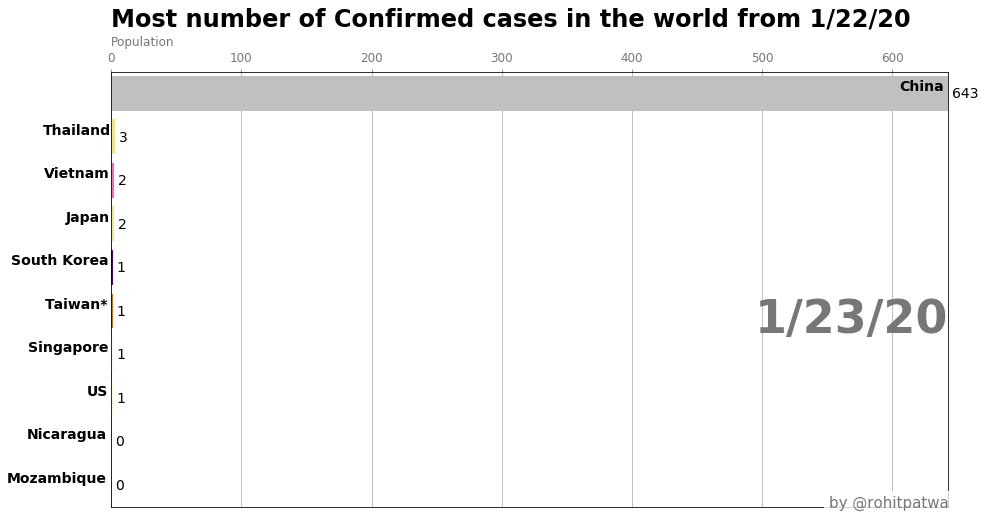

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart_conf, frames=adj_dates)
HTML(animator.to_jshtml())
# or use animator.to_html5_video() or animator.save() 


#### World Map with case density

In [33]:
plot_world_map_static('Confirmed')

In [68]:
plot_world_map_timeseries('Confirmed')

#### Line Chart 

In [69]:
plot_charts('Recovered')

#### Country rank 

In [72]:
plot_max('Recovered', 'Confirmed')

/home/rp/dev/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Growth Factor 

In [73]:
plot_growth_factor('Deaths', 'Confirmed')

#### China vs Others 

In [75]:
China_vs_Others('Deaths')